In this excercise we will run a basic RNN based language model and answer some questions about the code. It is advised to use GPU to run this. First run the code then answer the questions below that require modifying it.

In [1]:
# Some part of the code was referenced from below.
# https://github.com/pytorch/examples/tree/master/word_language_model 
# https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/02-intermediate/language_model

! git clone https://github.com/yunjey/pytorch-tutorial/
%cd pytorch-tutorial/tutorials/02-intermediate/language_model/

import torch
import torch.nn as nn
import numpy as np
from torch.nn.utils import clip_grad_norm_

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
embed_size = 128
hidden_size = 1024
num_layers = 1
num_epochs = 5
num_samples = 50     # number of words to be sampled
batch_size = 20
seq_length = 30
learning_rate = 0.002


fatal: destination path 'pytorch-tutorial' already exists and is not an empty directory.
/content/pytorch-tutorial/tutorials/02-intermediate/language_model


In [44]:
from data_utils import Dictionary, Corpus

# Load "Penn Treebank" dataset
corpus = Corpus()
ids = corpus.get_data('data/train.txt', batch_size)
print(ids)
vocab_size = len(corpus.dictionary)
print(vocab_size)
num_batches = ids.size(1) // seq_length
print(num_batches)

tensor([[   0,    1,    2,  ...,  152, 4955, 4150],
        [  93,  718,  590,  ...,  170, 6784,  133],
        [  27,  930,   42,  ...,  392, 4864,   26],
        ...,
        [ 997,   42,  507,  ...,  682, 6849, 6344],
        [ 392, 5518, 3034,  ..., 2264,   42, 3401],
        [4210,  467, 1496,  ..., 9999,  119, 1143]])
10000
1549


Model definition

In [3]:
# RNN based language model
class RNNLM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        super(RNNLM, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, x, h):
        # Embed word ids to vectors
        x = self.embed(x)
        
        # Forward propagate LSTM
        out, (h, c) = self.lstm(x, h)
        
        # Reshape output to (batch_size*sequence_length, hidden_size)
        out = out.reshape(out.size(0)*out.size(1), out.size(2))
        
        # Decode hidden states of all time steps
        out = self.linear(out)
        return out, (h, c)

Training .. should take a few minutes with GPU

In [4]:
model = RNNLM(vocab_size, embed_size, hidden_size, num_layers).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Truncated backpropagation
def detach(states):
    return [state.detach() for state in states] 


# Train the model
for epoch in range(num_epochs):
    # Set initial hidden and cell states
    states = (torch.zeros(num_layers, batch_size, hidden_size).to(device),
              torch.zeros(num_layers, batch_size, hidden_size).to(device))
    
    for i in range(0, ids.size(1) - seq_length, seq_length):
        # Get mini-batch inputs and targets
        inputs = ids[:, i:i+seq_length].to(device)
        targets = ids[:, (i+1):(i+1)+seq_length].to(device)
        
        # Forward pass
        states = detach(states)
        outputs, states = model(inputs, states)
        loss = criterion(outputs, targets.reshape(-1))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        step = (i+1) // seq_length
        if step % 100 == 0:
            print ('Epoch [{}/{}], Step[{}/{}], Loss: {:.4f}, Perplexity: {:5.2f}'
                   .format(epoch+1, num_epochs, step, num_batches, loss.item(), np.exp(loss.item())))

Epoch [1/5], Step[0/1549], Loss: 9.2154, Perplexity: 10050.66
Epoch [1/5], Step[100/1549], Loss: 6.0428, Perplexity: 421.07
Epoch [1/5], Step[200/1549], Loss: 5.9603, Perplexity: 387.74
Epoch [1/5], Step[300/1549], Loss: 5.7509, Perplexity: 314.47
Epoch [1/5], Step[400/1549], Loss: 5.6951, Perplexity: 297.40
Epoch [1/5], Step[500/1549], Loss: 5.1242, Perplexity: 168.05
Epoch [1/5], Step[600/1549], Loss: 5.1864, Perplexity: 178.83
Epoch [1/5], Step[700/1549], Loss: 5.3664, Perplexity: 214.10
Epoch [1/5], Step[800/1549], Loss: 5.2182, Perplexity: 184.60
Epoch [1/5], Step[900/1549], Loss: 5.0592, Perplexity: 157.46
Epoch [1/5], Step[1000/1549], Loss: 5.0750, Perplexity: 159.97
Epoch [1/5], Step[1100/1549], Loss: 5.3712, Perplexity: 215.11
Epoch [1/5], Step[1200/1549], Loss: 5.1832, Perplexity: 178.25
Epoch [1/5], Step[1300/1549], Loss: 5.1171, Perplexity: 166.84
Epoch [1/5], Step[1400/1549], Loss: 4.8107, Perplexity: 122.82
Epoch [1/5], Step[1500/1549], Loss: 5.1486, Perplexity: 172.20
Ep

Q2 (a) (10 points) The above code implements a version of truncated backpropagation through time. The implementation only requires the detach() function (L7-9 of the cell) defined above the loop and used once inside the training loop. Explain the implementation (compared to not using truncated backprop through time). What does the detach() call here achieve? Draw a computational graph.  You may choose to answer this question outside the notebook. When using using line 7-9 we will typically observe less GPU memory being used during training, explain why in your answer.


# **Q2.a Answer**
### main problems of BPTT

*   high cost of a single parameter update, which makes it impossible to use a large number of iterations.
*   the gradient becomes too small with long sequances.  if the number of time steps is long then far past sequance information will effectively be discarded.
*   large memoery and train time reqired to maintain the large sequence gradient updates through online backpropagation 









https://mmuratarat.github.io/2019-02-07/bptt-of-rnn

https://d2l.ai/chapter_recurrent-neural-networks/bptt.html#equation-eq-bptt-partial-ht-wh-gen

# gradient computation for RNN sequance

<img src="https://d2l.ai/_images/rnn-bptt.svg"/>

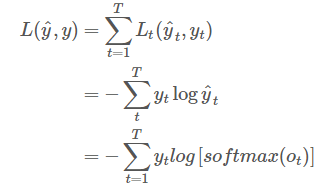
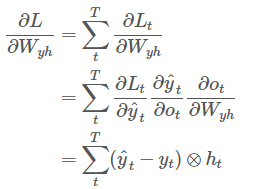
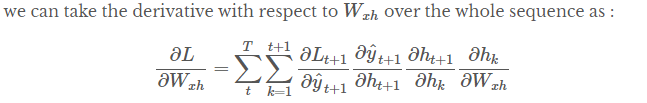

### Observes less GPU memory being used during training
Detaching the gradients in detach() function (L7-9 of the cell). will help to avoid too long RNN outputs are kept in memory before doing backprop on a batch. thus, leads to an approximation of the true gradient with limited memory needs

Now we will sample from the model

In [60]:
# Sample from the model
with torch.no_grad():
    with open('sample.txt', 'w') as f:
        # Set intial hidden ane cell states
        state = (torch.zeros(num_layers, 1, hidden_size).to(device),
                 torch.zeros(num_layers, 1, hidden_size).to(device))

        # Select one word id randomly
        prob = torch.ones(vocab_size)        
        # input = torch.multinomial(prob, num_samples=1).unsqueeze(1).to(device)
        input=torch.tensor([[100]]).to(device)
        print(input)
        for i in range(num_samples):
            # Forward propagate RNN 
            output, state = model(input, state)

            # Sample a word id
            prob = output.exp()
            word_id = torch.multinomial(prob, num_samples=1).item()
            # print(word_id)
            # Fill input with sampled word id for the next time step
            input.fill_(word_id)

            # File write
            word = corpus.dictionary.idx2word[word_id]
            # print(word)
            word = '\n' if word == '<eos>' else word + ' '
            f.write(word)

            if (i+1) % 100 == 0:
                print('Sampled [{}/{}] words and save to {}'.format(i+1, num_samples, 'sample.txt'))
! cat sample.txt

tensor([[100]], device='cuda:0')
standard a bureaucrats result 
we dinkins countries confidence the buy-out but prediction on europe as anything of action 's impact compatible at least being foods inflation the $ N billion of gm officials co banking 
but always foreign is an sisulu big letter france gold an <unk> 's 

Q2 (b) (5 points) Consider the sampling procedure. The current code samples the word to feed the model from the softmax at each output step feeding those to the next timestep. Copy below the above cell and modify this sampling to use a greedy sampling which selects the highest probability word at each time step to feed as the next input. 

In [71]:
# Sample greedily from the model

# Sample from the model
with torch.no_grad():
    with open('sample.txt', 'w') as f:
        # Set intial hidden ane cell states
        state = (torch.zeros(num_layers, 1, hidden_size).to(device),
                 torch.zeros(num_layers, 1, hidden_size).to(device))

        # Select one word id randomly
        prob = torch.ones(vocab_size)        
        # input = torch.multinomial(prob, num_samples=1).unsqueeze(1).to(device)
        input=torch.tensor([[100]]).to(device)
        print(input)

        for i in range(num_samples):
            # Forward propagate RNN 
            output, state = model(input, state)

            # Sample a word id
            prob = output.exp()
            # print(prob)
            # print(torch.argmax(torch.flatten(prob, start_dim=0)))
            # word_id = torch.multinomial(prob, num_samples=1).item()
            # print(torch.flatten(prob, start_dim=0))
            word_id=torch.argmax(torch.flatten(prob, start_dim=1)).item()
            # print(word_id)
            # Fill input with sampled word id for the next time step
            input.fill_(word_id)
            # print(input)
            # File write
            word = corpus.dictionary.idx2word[word_id]
            # print(word)
            word = '\n' if word == '<eos>' else word + ' '
            f.write(word)

            if (i+1) % 100 == 0:
                print('Sampled [{}/{}] words and save to {}'.format(i+1, num_samples, 'sample.txt'))
! cat sample.txt


tensor([[100]], device='cuda:0')

the <unk> of the <unk> of the <unk> of the <unk> of the <unk> of the <unk> of the <unk> of the <unk> of the <unk> of the <unk> of the <unk> 
the <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> 

In [72]:
print(26,corpus.dictionary.idx2word[26])

26 <unk>


Q2 (c) (5 points) The model above has learned a specific set of word embeddings. Write a function that takes in 2 words and prints the euclidean distance between their embeddings using the word embeddings from the above model. Use it to print the euclidean distance of the word "army" and the word "taxpayer". Refer to the sampling code for how to output the words corresponding to each index. To get the index you can use the function corpus.dictionary.word2idx. 

In [73]:
def calc_euclidean_dist(emba,emb2):
  return torch.norm(emb2 - emb1)

In [92]:
idx1=corpus.dictionary.word2idx['army']
idx2=corpus.dictionary.word2idx['taxpayer']
input=torch.tensor([[idx1],[idx2]]).to(device)
embedings=model.embed(input)
emb1=embedings[0][0]
print('emb1=',emb1)
emb2=embedings[1][0]
print('emb2=',emb2)
print('euclidean_dist=',calc_euclidean_dist(emb1,emb2))

emb1= tensor([-2.2605,  1.8347,  0.3290,  1.2438,  0.5797, -0.8029, -1.7835, -1.7043,
        -1.9972,  0.8936,  0.4586,  0.9676,  0.6952, -0.4859,  0.3806,  0.0866,
         1.0970, -0.0312, -1.0015, -1.3252, -1.2698,  0.4583, -0.1687,  0.4805,
         0.9958, -0.8913,  0.3243,  0.0583,  0.1725,  1.1637,  0.2934,  1.7897,
         0.6411, -0.1767, -0.1446,  1.2658,  2.5794, -1.3246, -0.8371,  0.2599,
         1.9956,  0.8422,  1.2673, -0.0601, -0.7049,  1.8812,  0.5234, -1.7571,
        -0.2755,  0.1172,  0.0358, -1.3997, -0.7592,  0.3979,  0.6130,  0.4447,
        -1.0921, -0.8210,  0.7058,  1.2346, -0.6560, -1.9122, -2.8719,  1.5943,
         0.0417,  0.1118,  0.3425, -0.1908, -0.2210, -0.9062, -0.6764, -2.1598,
         0.4907,  0.1816, -1.0560, -0.2304, -0.8227, -1.6182, -0.4912, -1.7678,
        -0.2781,  0.1765, -0.4360,  0.1429,  0.8224, -0.3750,  0.8260, -1.5832,
         1.8599, -1.1047, -0.6410, -0.3978,  0.0879, -0.4928, -1.1259,  0.1938,
        -0.1726, -0.5636, -2.0747,